<a href="https://colab.research.google.com/github/AlexKinda1/Projet-InsightBoost/blob/main/D%C3%A9tection_du_glaucome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PHASE 1: EXPLORATION DES DONNEES
###ETAPE 1.1: Chargement et Analyse du fichier de labels

connexion à google drive
Mounted at /content/drive
Connexion réussie

 Fichier 'Labels.csv' chargé avec succès depuis le bon emplacement.

--- Analyse de la Distribution des Classes ---
Label
GON+    548
GON-    199
Name: count, dtype: int64

--- Affichage d'un exemple pour chaque classe ---


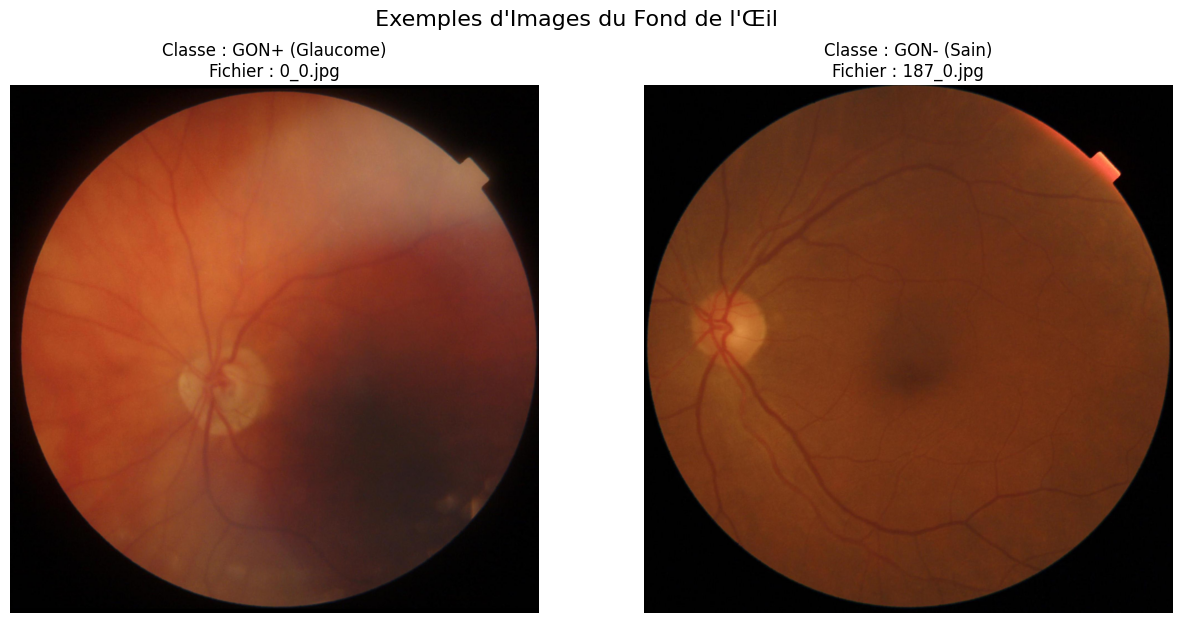

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
import cv2
import os
from google.colab import drive

print("connexion à google drive")
drive.mount('/content/drive')
print("Connexion réussie")

BASE_PATH = '/content/drive/My Drive/Projet_Glaucome/'

CSV_PATH = os.path.join(BASE_PATH, 'Labels.csv')
IMAGE_PATH = os.path.join(BASE_PATH, 'images/')

# --- D. Chargement et Analyse des Labels ---
try:
    df_labels = pd.read_csv(CSV_PATH)
    print("\n Fichier 'Labels.csv' chargé avec succès depuis le bon emplacement.")

    print("\n--- Analyse de la Distribution des Classes ---")
    class_distribution = df_labels['Label'].value_counts()
    print(class_distribution)

    # --- E. Visualisation d'Images Échantillons ---
    print("\n--- Affichage d'un exemple pour chaque classe ---")
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Image Glaucomateuse (GON+)
    sample_gon_plus = df_labels[df_labels['Label'] == 'GON+'].iloc[0]
    full_path_plus = os.path.join(IMAGE_PATH, sample_gon_plus['Image Name'])
    image_plus = cv2.imread(full_path_plus)
    image_plus = cv2.cvtColor(image_plus, cv2.COLOR_BGR2RGB)
    axes[0].imshow(image_plus)
    axes[0].set_title(f"Classe : GON+ (Glaucome)\nFichier : {sample_gon_plus['Image Name']}", fontsize=12)
    axes[0].axis('off')

    # Image Saine (GON-)
    sample_gon_minus = df_labels[df_labels['Label'] == 'GON-'].iloc[0]
    full_path_minus = os.path.join(IMAGE_PATH, sample_gon_minus['Image Name'])
    image_minus = cv2.imread(full_path_minus)
    image_minus = cv2.cvtColor(image_minus, cv2.COLOR_BGR2RGB)
    axes[1].imshow(image_minus)
    axes[1].set_title(f"Classe : GON- (Sain)\nFichier : {sample_gon_minus['Image Name']}", fontsize=12)
    axes[1].axis('off')

    plt.suptitle(" Exemples d'Images du Fond de l'Œil", fontsize=16)
    plt.show()

except FileNotFoundError:
    print(f"\nERREUR : Le fichier ou le dossier est toujours introuvable.")
    print(f"Veuillez vérifier que le chemin suivant est 100% correct : {BASE_PATH}")
except Exception as e:
    print(f"Une erreur est survenue : {e}")

# Phase 2 : Prétraitement et Augmentation des Données
### **1. Séparation Stratifiée des Données** : Nous allons diviser notre jeu de données en trois sous-ensembles distincts : Training Set (75%), Validation Set (15%), Test Set (15%)

### **2. Data Augmentation**: Transformations aléatoires : rotations, zooms, légers décalages, etc.

### **3. Création des générateurs de données**


In [8]:
# Séparation stratifiée des données
X_train, X_temp, y_train, y_temp = train_test_split(
    df_labels['Image Name'],
    df_labels['Label'],
    test_size = 0.3,
    random_state = 42,
    stratify = df_labels['Label']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

train_df = pd.DataFrame({'Image Name':X_train, 'Label': y_train})
validation_df = pd.DataFrame({'Image Name': X_val, 'Label': y_val})
test_df = pd.DataFrame({'Image Name': X_test, 'Label': y_test})

print("\n Repartition des données")
print(f"Taille de l'ensemble d'entrainement: {len(train_df)} images")
print(f"Taille de l'ensemble de validation: {len(validation_df)} images")
print(f"Taille de l'ensemble de test: {len(test_df)} images")
print("\n Distribution dans l'ensemble d'entrainement")
print(train_df['Label'].value_counts(normalize=True))
print("\nDistribution dans l'ensemble de validation :")
print(validation_df['Label'].value_counts(normalize=True))


 Repartition des données
Taille de l'ensemble d'entrainement: 522 images
Taille de l'ensemble de validation: 112 images
Taille de l'ensemble de test: 113 images

 Distribution dans l'ensemble d'entrainement
Label
GON+    0.733716
GON-    0.266284
Name: proportion, dtype: float64

Distribution dans l'ensemble de validation :
Label
GON+    0.732143
GON-    0.267857
Name: proportion, dtype: float64


In [9]:
# Configuration des Générateurs d'Images
IMG_SIZE = 224
BATCH_SIZE = 32

# Generateur pour l'entrainement
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 10,
    height_shift_range = 10,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Générateur pour la validation et le test (SANS augmentation)
val_test_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Création des flux de données depuis les DataFrames
print("Création des générateurs de données")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Surtout ne pas mélanger les données de test pour une évaluation reproductible.
)


Création des générateurs de données
Found 522 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.
Found 113 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

IMG_SIZE = 224

print("\n--- Chargement du modèle de base EfficientNetV2B0 ---")

base_model = EfficientNetV2B0(
    weights = 'imagenet',
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False
)

base_model.trainable = False

print("La base du modèle pré-entrainé a été gélée.")
print(f"le nombre de couche dans la base est: {len(base_model.layers)}")

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.3)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs = base_model.input, outputs = outputs)

print("\n--- Modèle final assemblé ---")

model.summary()





--- Chargement du modèle de base EfficientNetV2B0 ---
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
La base du modèle pré-entrainé a été gélée.
le nombre de couche dans la base est: 270

--- Modèle final assemblé ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(train_generator.classes),
    y = train_generator.classes
)

class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

print(f"Indices des classes : {train_generator.class_indices}")
print(f"Poids calculés : {class_weights_dict}")
print("Le modèle sera plus pénalisé pour les erreurs sur la classe 0 (GON-).")

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', AUC(name='auc')]
)

# --- D. Configuration des Callbacks (nos gardiens) ---
print("\n--- Configuration des Callbacks ---")

# Chemin où sera sauvegardé le meilleur modèle
best_model_path = os.path.join(BASE_PATH, 'glaucoma_detection_best_model.keras')

checkpoint = ModelCheckpoint(
    filepath = best_model_path,
    monitor = 'val_auc',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor = 'val_auc',
    mode = 'max',
    verbose = 1,
    patience = 10,
    restore_best_weights = True
)

print("\n--- Lancement de l'entraînement de la tête de classification ---")

EPOCHS = 50

history = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = validation_generator,
    class_weight = class_weights_dict,
    callbacks = [checkpoint, early_stopping]
)

print("\n Entraînement de la tête terminé !")

Indices des classes : {'GON+': 0, 'GON-': 1}
Poids calculés : {np.int64(0): np.float64(0.6814621409921671), np.int64(1): np.float64(1.8776978417266188)}
Le modèle sera plus pénalisé pour les erreurs sur la classe 0 (GON-).

--- Configuration des Callbacks ---

--- Lancement de l'entraînement de la tête de classification ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4959 - auc: 0.4804 - loss: 0.6982
Epoch 1: val_auc improved from -inf to 0.52602, saving model to /content/drive/My Drive/Projet_Glaucome/glaucoma_detection_best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 189s 10s/step - accuracy: 0.4933 - auc: 0.4811 - loss: 0.6983 - val_accuracy: 0.2679 - val_auc: 0.5260 - val_loss: 0.7257
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4584 - auc: 0.4391 - loss: 0.7059
Epoch 2: val_auc did not improve from 0.52602
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4565 - auc: 0.4381 - loss: 0.7063 - val_accuracy: 0.2679 - val_auc: 0.5000 - val_loss: 0.7031
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4986 - auc: 0.4909 - loss: 0.7148
Epoch 3: val_auc did not improve from 0.52602
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5007 - auc: 0.4916 - loss: 0.7139 - val_accuracy: 0.7321 - val_auc: 0.5000 - val_loss: 0.6755
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

print("Debut du fine-tunning")

base_model.trainable=True

fine_tune_at = len(base_model.layers) - 40

for layer in base_model.layers[:fine_tune_at]:
  base_model.trainable = False

print(f"Les couches AVANT la couche {fine_tune_at} sont gelées.")
print(f"Les couches APRÈS la couche {fine_tune_at} sont entraînables (fine-tuning).")

optimizer = Adam(learning_rate = 1e-5)

model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy', AUC(name = 'auc')]
)

print("\n--- Modèle re-compilé pour le fine-tuning ---")
model.summary()

print("\n--- Lancement du fine-tuning ---")

fine_tune_epochs = 50
total_epochs = 17 + fine_tune_epochs

hitory_fine_tune = model.fit(
    train_generator,
    epochs = total_epochs,
    initial_epoch = 17,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping]
)


Debut du fine-tunning
Les couches AVANT la couche 230 sont gelées.
Les couches APRÈS la couche 230 sont entraînables (fine-tuning).

--- Modèle re-compilé pour le fine-tuning ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)


--- Lancement du fine-tuning ---
Epoch 18/67
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3726 - auc: 0.5069 - loss: 0.7077
Epoch 18: val_auc did not improve from 0.56992
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.3725 - auc: 0.5080 - loss: 0.7071 - val_accuracy: 0.2679 - val_auc: 0.5000 - val_loss: 0.7286
Epoch 19/67
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3528 - auc: 0.4569 - loss: 0.7106
Epoch 19: val_auc did not improve from 0.56992
17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.3530 - auc: 0.4579 - loss: 0.7103 - val_accuracy: 0.2679 - val_auc: 0.4785 - val_loss: 0.7253
Epoch 20/67
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4005 - auc: 0.5037 - loss: 0.7244
Epoch 20: val_auc did not improve from 0.56992
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4003 - auc: 0.5050 - loss: 0.7227 - val_accuracy: 0.2679 - val_auc: 0.5000 - val_loss: 0.7232
Epoch 21/67
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3860 - auc: 0.5279 - loss:

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print("--- Début du Fine-Tuning Agressif ---")

best_model_path = os.path.join(BASE_PATH, 'glaucoma_detection_best_model.keras')
model = load_model(best_model_path)
print(" Meilleur modèle précédent chargé.")

# # Attempt to get the base model layer (original code) - Removed due to error
# try:
#     base_model = model.get_layer('efficientnetv2b0')
#     print(" Base du modèle récupérée par son nom.")
# except ValueError:
#     print("ERREUR: Impossible de trouver la couche 'efficientnetv2b0'. Vérifiez le nom dans model.summary().")
#     # Affiche le nom de toutes les couches pour aider au débogage
#     for layer in model.layers:
#         print(layer.name)

# Set all layers to trainable first
for layer in model.layers:
    layer.trainable = True

# Calculate the fine-tune_at index based on the total number of layers in the loaded model
fine_tune_at = len(model.layers) // 2

# Freeze layers before fine_tune_at
for i, layer in enumerate(model.layers):
    if i < fine_tune_at:
        layer.trainable = False

print(f"\nLes couches AVANT la couche {fine_tune_at} sont gelées.")
print(f"Les couches APRÈS la couche {fine_tune_at} sont entraînables.")


optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\n--- Modèle re-compilé pour un fine-tuning plus agressif ---")
model.summary()


print("\n--- Reprise de l'entraînement ---")

continue_epochs = 50
# The initial_epoch should be the number of epochs already completed in the previous training phase.
# Based on the output of the previous cell, the early stopping happened at epoch 17, so the best weights
# were restored from epoch 7. Let's use 7 as the initial epoch for fine-tuning.
initial_epoch_for_fine_tune = 7
total_epochs = initial_epoch_for_fine_tune + continue_epochs


history_fine_tune_2 = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=initial_epoch_for_fine_tune,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping]
)

print("\n Phase de fine-tuning agressif terminée !")

--- Début du Fine-Tuning Agressif ---
 Meilleur modèle précédent chargé.

Les couches AVANT la couche 136 sont gelées.
Les couches APRÈS la couche 136 sont entraînables.

--- Modèle re-compilé pour un fine-tuning plus agressif ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 4,609,193 (17.58 MB)

 Non-trainable params: 1,311,400 (5.00 MB)


--- Reprise de l'entraînement ---
Epoch 8/57
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6188 - auc: 0.5792 - loss: 0.6954
Epoch 8: val_auc did not improve from 0.56992
17/17 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.6172 - auc: 0.5771 - loss: 0.6956 - val_accuracy: 0.3304 - val_auc: 0.4878 - val_loss: 0.6939
Epoch 9/57
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4830 - auc: 0.4502 - loss: 0.7334
Epoch 9: val_auc did not improve from 0.56992
17/17 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.4818 - auc: 0.4512 - loss: 0.7326 - val_accuracy: 0.2679 - val_auc: 0.3476 - val_loss: 0.7512
Epoch 10/57
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4160 - auc: 0.4517 - loss: 0.7209
Epoch 10: val_auc improved from 0.56992 to 0.58171, saving model to /content/drive/My Drive/Projet_Glaucome/glaucoma_detection_best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.4190 - auc: 0.4542 - loss: 0.7199 - val_accuracy: 0.3571 - val_auc: 0.5817 - val_loss: 0.

Meilleur modèle chargé pour l'évaluation


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step

--- Classification Report ---
              precision    recall  f1-score   support

        GON+       1.00      0.01      0.02        83
        GON-       0.27      1.00      0.42        30

    accuracy                           0.27       113
   macro avg       0.63      0.51      0.22       113
weighted avg       0.81      0.27      0.13       113


--- Matrice de Confusion ---


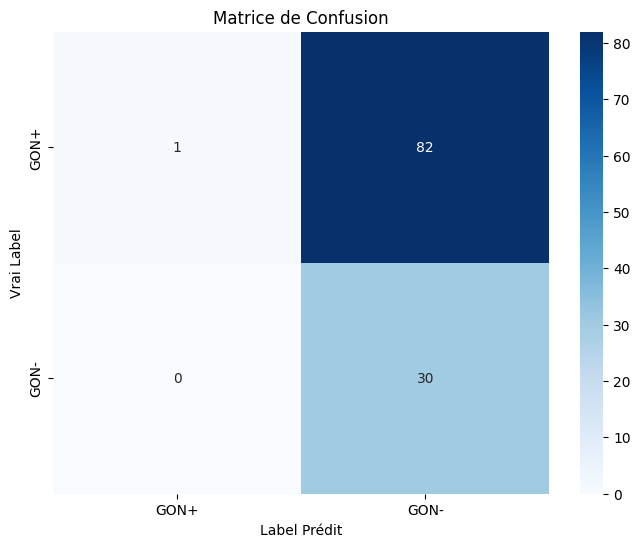

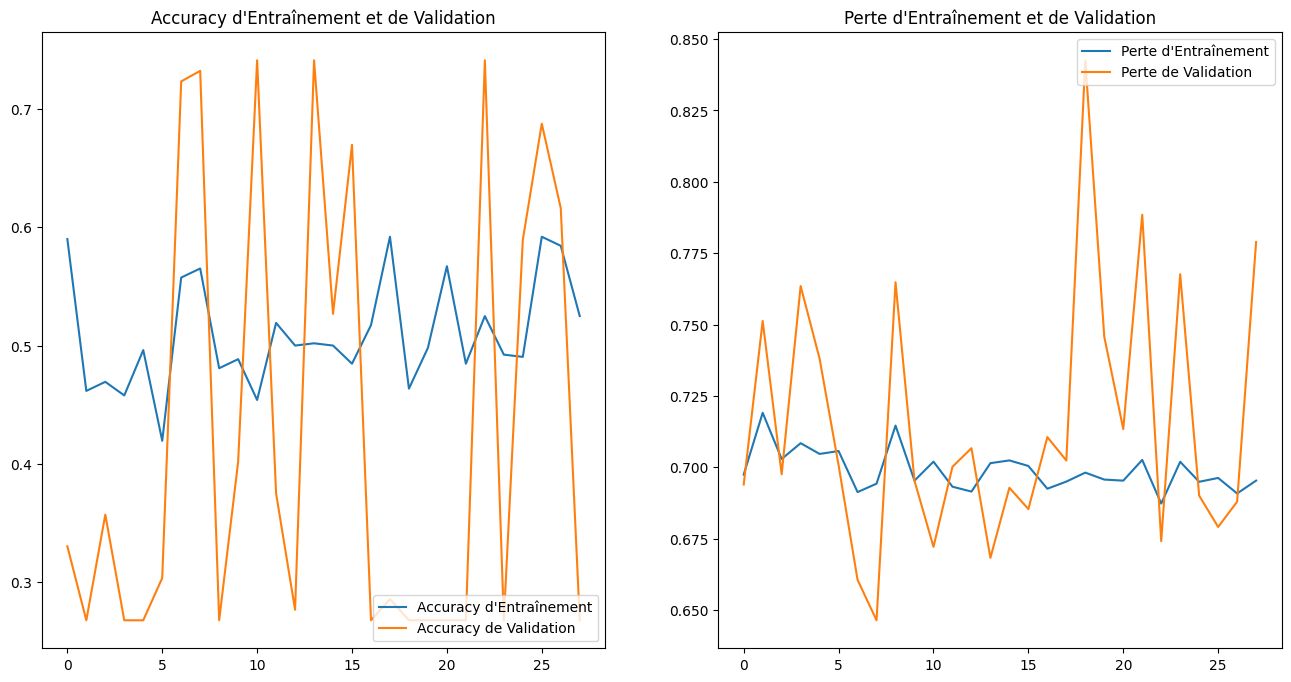

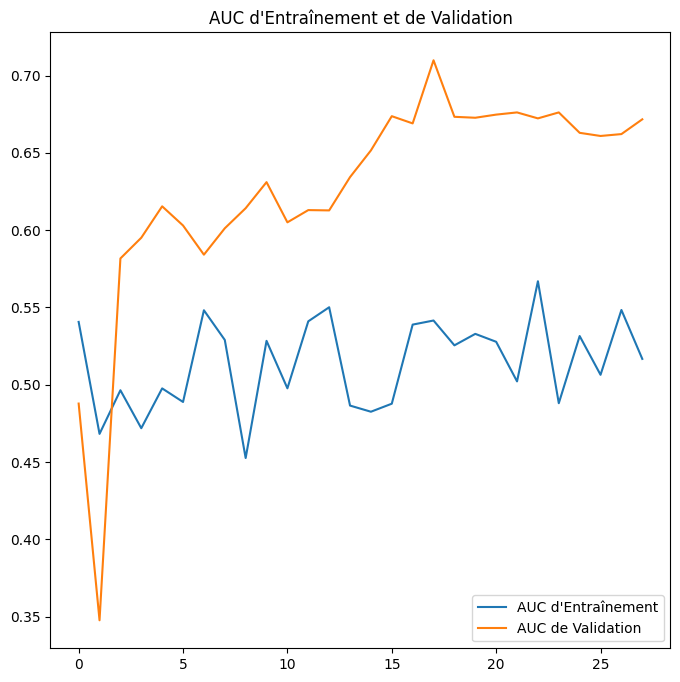


🎉 Phase 5 terminée !


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

best_model_path = os.path.join(BASE_PATH, 'glaucoma_detection_best_model.keras')
model = load_model(best_model_path)
print("Meilleur modèle chargé pour l'évaluation")

predictions_proba = model.predict(test_generator)
predictions = (predictions_proba > 0.5).astype(int)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\n--- Classification Report ---")
print(classification_report(true_labels, predictions, target_names=class_labels))

print("\n--- Matrice de Confusion ---")
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de Confusion')
plt.ylabel('Vrai Label')
plt.xlabel('Label Prédit')
plt.show()

history_dict = history_fine_tune_2.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Accuracy d'Entraînement")
plt.plot(epochs_range, val_acc, label="Accuracy de Validation")
plt.legend(loc='lower right')
plt.title("Accuracy d'Entraînement et de Validation")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Perte d'Entraînement")
plt.plot(epochs_range, val_loss, label="Perte de Validation")
plt.legend(loc='upper right')
plt.title("Perte d'Entraînement et de Validation")
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, auc, label="AUC d'Entraînement")
plt.plot(epochs_range, val_auc, label="AUC de Validation")
plt.legend(loc='lower right')
plt.title('AUC d\'Entraînement et de Validation')
plt.show()

print("\n Phase 5 terminée !")

In [ ]:
from google.colab import files
import os

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\ API Kaggle configurée avec succès !")

Saving kaggle.json to kaggle.json
\ API Kaggle configurée avec succès !


In [ ]:
!kaggle datasets download -d victorlemosml/refuge2

print("Téléchargement terminé")

!unzip -q refuge2.zip

print("Décompression terminée.")

Dataset URL: https://www.kaggle.com/datasets/victorlemosml/refuge2
License(s): unknown
 97% 1.24G/1.27G [00:11<00:00, 110MB/s] 
100% 1.27G/1.27G [00:11<00:00, 116MB/s]
Téléchargement terminé
Décompression terminée.


In [ ]:
!ls -R

.:
kaggle.json  REFUGE2  refuge2.zip  sample_data

./REFUGE2:
test  train  val

./REFUGE2/test:
images	mask

./REFUGE2/test/images:
T0001.jpg  T0059.jpg  T0117.jpg  T0175.jpg  T0233.jpg  T0291.jpg  T0349.jpg
T0002.jpg  T0060.jpg  T0118.jpg  T0176.jpg  T0234.jpg  T0292.jpg  T0350.jpg
T0003.jpg  T0061.jpg  T0119.jpg  T0177.jpg  T0235.jpg  T0293.jpg  T0351.jpg
T0004.jpg  T0062.jpg  T0120.jpg  T0178.jpg  T0236.jpg  T0294.jpg  T0352.jpg
T0005.jpg  T0063.jpg  T0121.jpg  T0179.jpg  T0237.jpg  T0295.jpg  T0353.jpg
T0006.jpg  T0064.jpg  T0122.jpg  T0180.jpg  T0238.jpg  T0296.jpg  T0354.jpg
T0007.jpg  T0065.jpg  T0123.jpg  T0181.jpg  T0239.jpg  T0297.jpg  T0355.jpg
T0008.jpg  T0066.jpg  T0124.jpg  T0182.jpg  T0240.jpg  T0298.jpg  T0356.jpg
T0009.jpg  T0067.jpg  T0125.jpg  T0183.jpg  T0241.jpg  T0299.jpg  T0357.jpg
T0010.jpg  T0068.jpg  T0126.jpg  T0184.jpg  T0242.jpg  T0300.jpg  T0358.jpg
T0011.jpg  T0069.jpg  T0127.jpg  T0185.jpg  T0243.jpg  T0301.jpg  T0359.jpg
T0012.jpg  T0070.jpg  T0128.jpg 

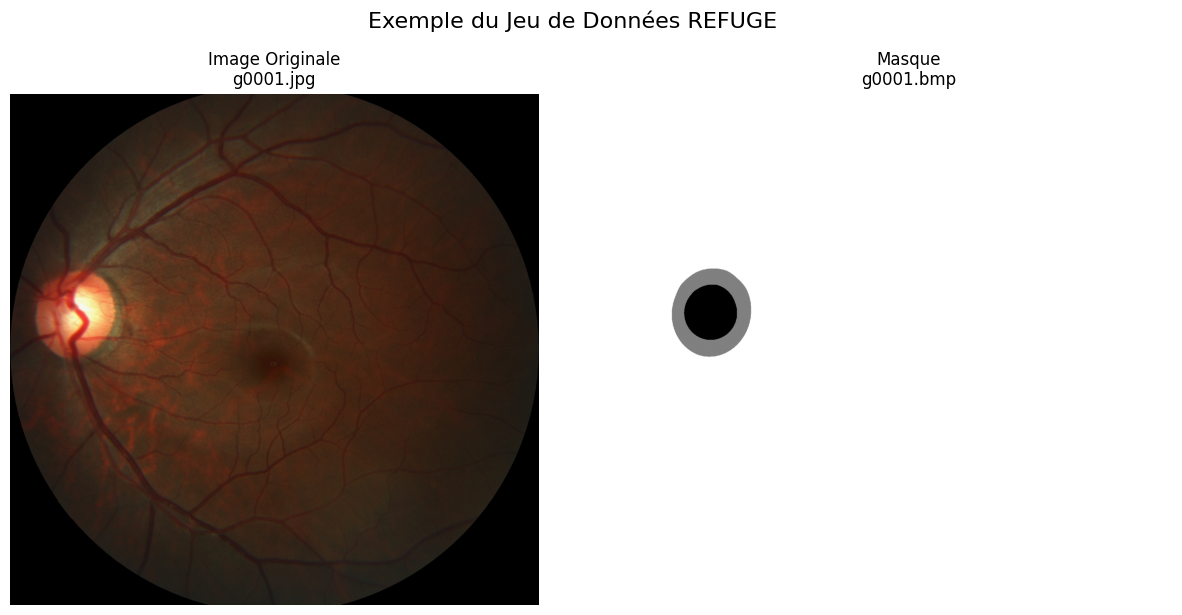

In [ ]:
import matplotlib.pyplot as plt
import cv2

refuge_images_path = 'REFUGE2/train/images'
refuge_masks_path = 'REFUGE2/train/mask'

refuge_images = sorted(os.listdir(refuge_images_path))
refuge_masks = sorted(os.listdir(refuge_masks_path))

#Visualisation
sample_image_name = refuge_images[0]
sample_mask_name = refuge_masks[0]

sample_image = cv2.imread(os.path.join(refuge_images_path, sample_image_name))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

sample_mask = cv2.imread(os.path.join(refuge_masks_path, sample_mask_name), cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(sample_image)
axes[0].set_title(f"Image Originale\n{sample_image_name}")
axes[0].axis('off')

axes[1].imshow(sample_mask, cmap='gray')
axes[1].set_title(f"Masque\n{sample_mask_name}")
axes[1].axis('off')

plt.suptitle("Exemple du Jeu de Données REFUGE", fontsize=16)
plt.show()

Trouvé 320 images pour l'entraînement.
Trouvé 80 images pour la validation.

✅ Pipeline de données tf.data robuste créé avec succès.

✅ Modèle U-Net construit et compilé.

--- Lancement de l'entraînement du U-Net ---
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_36']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - dice_coeff: 0.8324 - loss: 0.4057 - val_dice_coeff: 0.9796 - val_loss: 0.1572
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 152s 8s/step - dice_coeff: 0.9807 - loss: 0.1110 - val_dice_coeff: 0.9939 - val_loss: 0.0737
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step - dice_coeff: 0.9912 - loss: 0.0539 - val_dice_coeff: 0.9927 - val_loss: 0.0301
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 152s 8s/step - dice_coeff: 0.9931 - loss: 0.0280 - val_dice_coeff: 0.9949 - val_loss: 0.0335
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 156s 8s/step - dice_coeff: 0.9928 - loss: 0.0297 - val_dice_coeff: 0.9944 - val_loss: 0.0209
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - dice_coeff: 0.9936 - loss: 0.0227 - val_dice_coeff: 0.9947 - val_loss: 0.0191
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step - dice_coeff: 0.9936 - loss: 0.0210 - val_dice_coeff: 0.9949 - val_loss: 0.0177
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 159s 8s/step - dice_coeff: 0.9940 - loss: 0.0200 - val_d

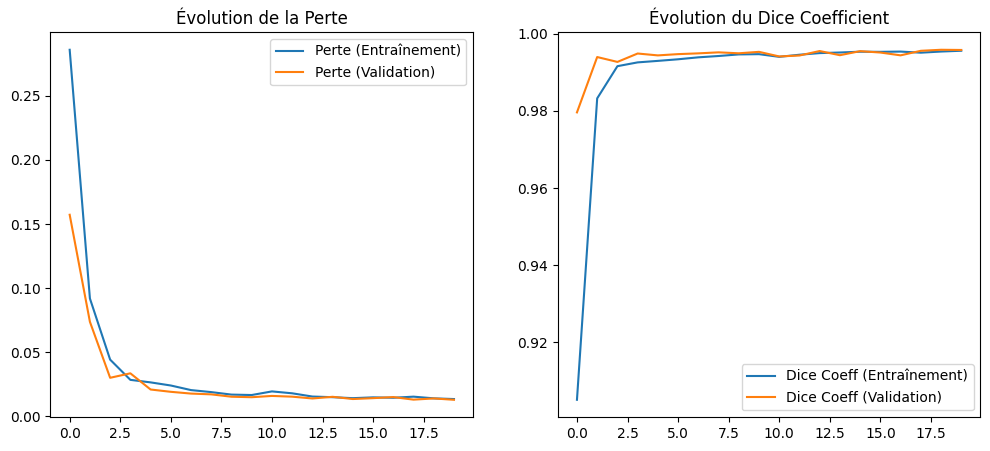

In [10]:
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

BASE_PATH = '/content/drive/My Drive/Projet_Glaucome/'

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16


all_train_image_paths = sorted(glob.glob("REFUGE2/train/images/*.jpg"))
all_train_mask_paths = sorted(glob.glob("REFUGE2/train/mask/*.bmp"))

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    all_train_image_paths,
    all_train_mask_paths,
    test_size=0.2,
    random_state=42
)
print(f"Trouvé {len(train_image_paths)} images pour l'entraînement.")
print(f"Trouvé {len(val_image_paths)} images pour la validation.")

# --- C. Création du pipeline tf.data (SOLUTION ROBUSTE) ---
def load_and_preprocess_wrapper(image_path, mask_path):

    image, mask = tf.py_function(func=load_with_opencv,
                                 inp=[image_path, mask_path],
                                 Tout=[tf.float32, tf.float32])

    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    return image, mask

def load_with_opencv(image_path, mask_path):

    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')

    # Charger l'image avec OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convertir en RGB
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image / 255.0

    # Charger le masque avec OpenCV en niveaux de gris
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = mask / 255.0
    # Ajouter une dimension de canal pour correspondre à la sortie du modèle
    mask = np.expand_dims(mask, axis=-1)

    return image.astype(np.float32), mask.astype(np.float32)

# Création des datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
val_dataset = val_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

# Préparation pour l'entraînement
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(len(train_image_paths)).batch(BATCH_SIZE).repeat().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print("\n✅ Pipeline de données tf.data robuste créé avec succès.")


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def build_unet(input_shape):
    inputs = Input(input_shape)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

unet_model = build_unet((IMG_HEIGHT, IMG_WIDTH, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coeff])
print("\n✅ Modèle U-Net construit et compilé.")


print("\n--- Lancement de l'entraînement du U-Net ---")

EPOCHS_UNET = 20
steps_per_epoch = len(train_image_paths) // BATCH_SIZE
validation_steps = len(val_image_paths) // BATCH_SIZE

history_unet = unet_model.fit(
    train_dataset,
    epochs=EPOCHS_UNET,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

# Sauvegarder le modèle
unet_model_path = os.path.join(BASE_PATH, 'unet_optic_disc_segmentation.keras')
unet_model.save(unet_model_path)
print(f"\n🎉 Entraînement du U-Net terminé ! Modèle sauvegardé à : {unet_model_path}")

# --- F. Visualisation de la performance ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_unet.history['loss'], label='Perte (Entraînement)')
plt.plot(history_unet.history['val_loss'], label='Perte (Validation)')
plt.title('Évolution de la Perte')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_unet.history['dice_coeff'], label='Dice Coeff (Entraînement)')
plt.plot(history_unet.history['val_dice_coeff'], label='Dice Coeff (Validation)')
plt.title('Évolution du Dice Coefficient')
plt.legend()
plt.show()

--- Évaluation visuelle du modèle U-Net ---


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_36']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


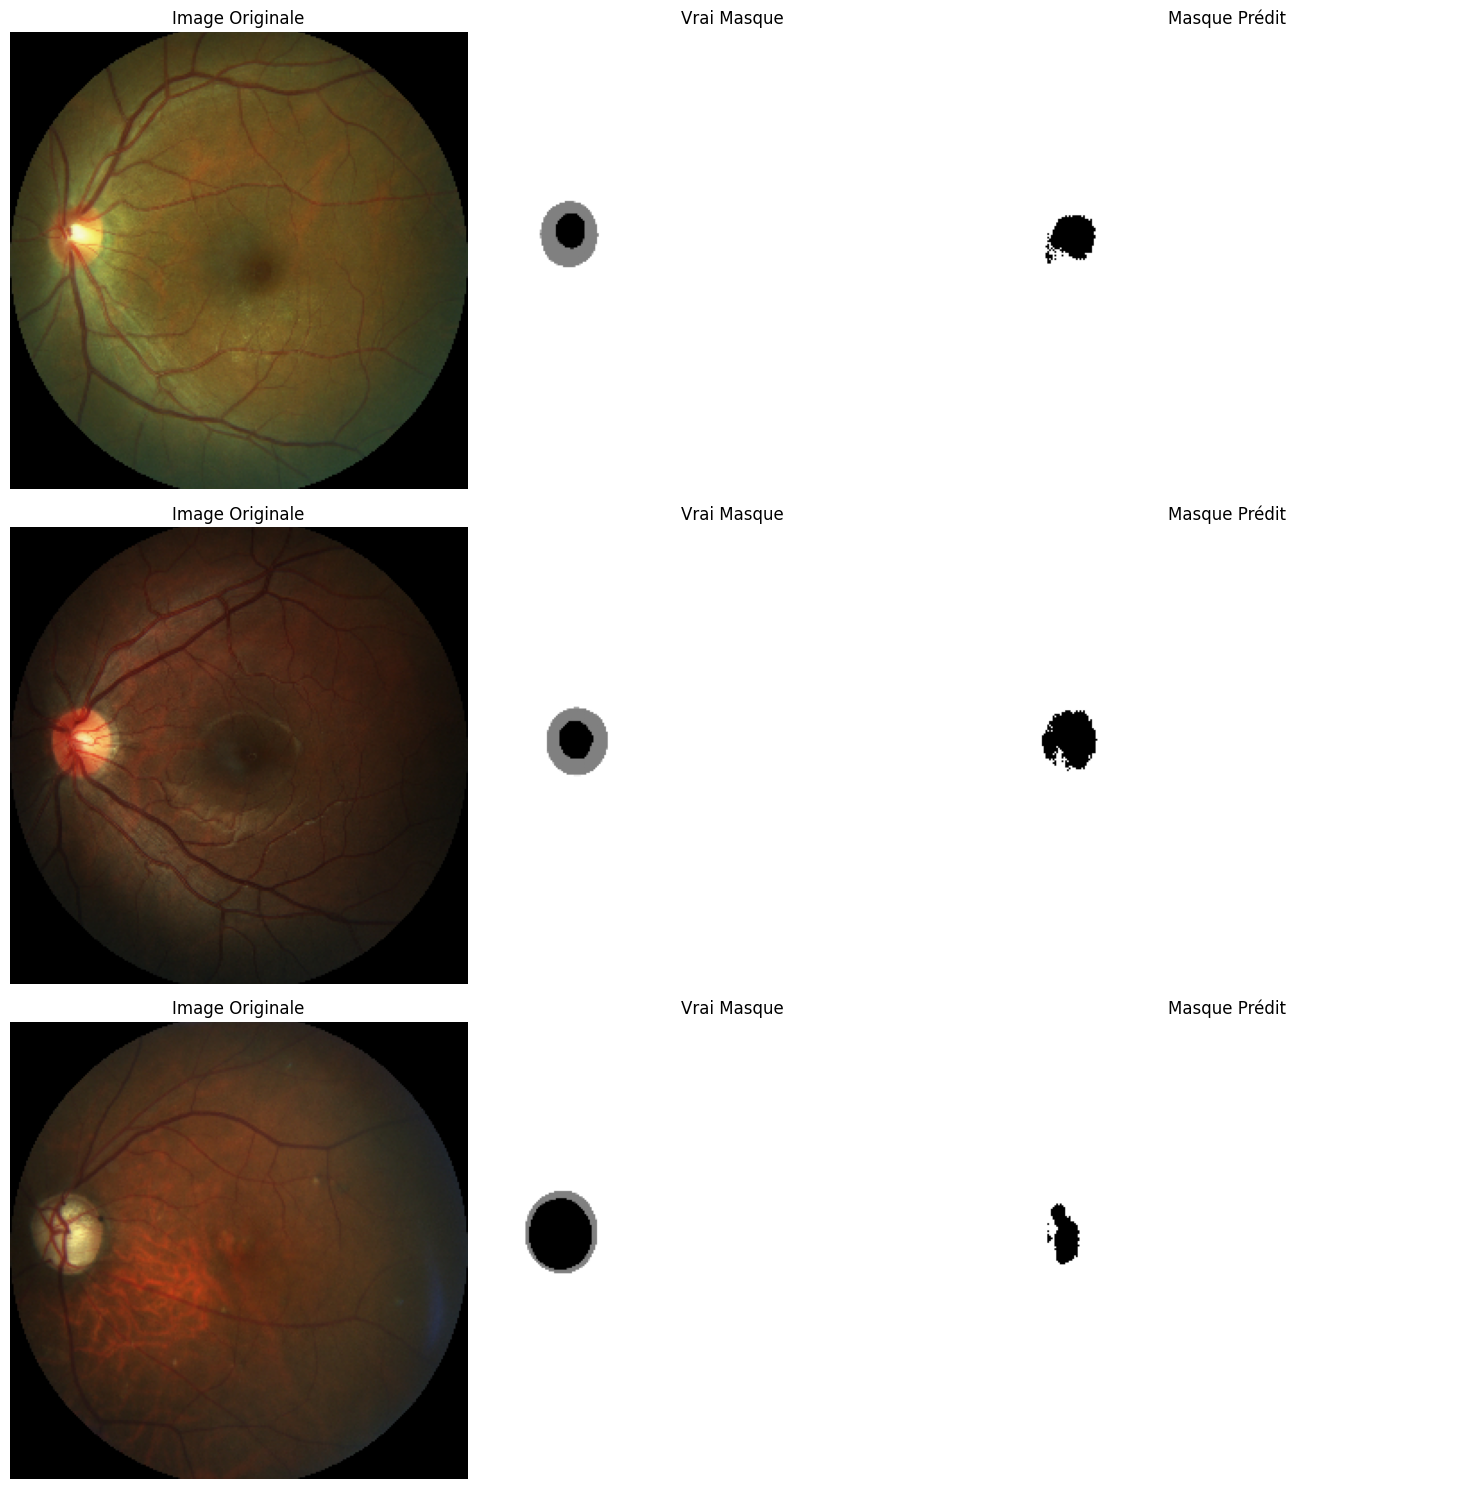

In [11]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Évaluation visuelle du modèle U-Net ---")

# On prend un lot de données du générateur de validation
val_images, val_masks = next(iter(val_dataset.take(1)))

# On utilise le U-Net pour prédire les masques sur ce lot d'images
predicted_masks = unet_model.predict(val_images)

# Afficher quelques exemples (par exemple les 3 premiers)
num_examples_to_show = 3
plt.figure(figsize=(15, num_examples_to_show * 5))

for i in range(num_examples_to_show):
    # Affichage de l'image originale
    plt.subplot(num_examples_to_show, 3, i*3 + 1)
    plt.imshow(val_images[i])
    plt.title("Image Originale")
    plt.axis('off')

    # Affichage du vrai masque
    plt.subplot(num_examples_to_show, 3, i*3 + 2)
    plt.imshow(np.squeeze(val_masks[i]), cmap='gray')
    plt.title("Vrai Masque")
    plt.axis('off')

    # Affichage du masque prédit
    # On utilise un seuil de 0.5 pour binariser la sortie du modèle (probabilités)
    predicted_mask_binary = (predicted_masks[i] > 0.5).astype(np.uint8)
    plt.subplot(num_examples_to_show, 3, i*3 + 3)
    plt.imshow(np.squeeze(predicted_mask_binary), cmap='gray')
    plt.title("Masque Prédit")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# ==============================================================================
# PHASE 7 : CRÉATION DU JEU DE DONNÉES RECADRÉ
# ==============================================================================
import cv2
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm # Pour afficher une barre de progression

# --- A. Chargement de notre U-Net entraîné ---
unet_model_path = os.path.join(BASE_PATH, 'unet_optic_disc_segmentation.keras')
# On ajoute le `custom_objects` pour qu'il reconnaisse notre métrique personnalisée
unet_model = tf.keras.models.load_model(unet_model_path, custom_objects={'dice_coeff': dice_coeff})
print("✅ Modèle U-Net chargé.")

# --- B. Préparation des dossiers ---
# Chemin vers vos images originales
original_images_path = os.path.join(BASE_PATH, 'images/')
# Création d'un nouveau dossier pour les images recadrées
cropped_images_path = os.path.join(BASE_PATH, 'cropped_images/')
os.makedirs(cropped_images_path, exist_ok=True)
print(f"Les images recadrées seront sauvegardées dans : {cropped_images_path}")

# --- C. Itération, Prédiction et Recadrage ---
# On utilise le DataFrame original `df_labels` qui contient le nom de toutes vos images
image_filenames = df_labels['image_id'].tolist()

print("\n--- Début du processus de prédiction et de recadrage ---")

for filename in tqdm(image_filenames):
    try:
        # 1. Charger l'image originale
        img_path = os.path.join(original_images_path, filename)
        original_img = cv2.imread(img_path)
        original_h, original_w, _ = original_img.shape

        # 2. Prétraiter l'image pour le U-Net
        img_for_unet = cv2.resize(original_img, (IMG_WIDTH, IMG_HEIGHT))
        img_for_unet = img_for_unet / 255.0
        img_for_unet = np.expand_dims(img_for_unet, axis=0) # Ajouter la dimension du lot

        # 3. Prédire le masque
        predicted_mask_normalized = unet_model.predict(img_for_unet, verbose=0)
        predicted_mask = (predicted_mask_normalized[0] * 255).astype(np.uint8)

        # 4. Trouver les contours du disque optique sur le masque prédit
        contours, _ = cv2.findContours(predicted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # On prend le plus grand contour trouvé
            largest_contour = max(contours, key=cv2.contourArea)
            # On calcule la boîte de délimitation (bounding box)
            x, y, w, h = cv2.boundingRect(largest_contour)

            # 5. Redimensionner les coordonnées de la boîte pour l'image originale
            x_orig = int(x * original_w / IMG_WIDTH)
            y_orig = int(y * original_h / IMG_HEIGHT)
            w_orig = int(w * original_w / IMG_WIDTH)
            h_orig = int(h * original_h / IMG_HEIGHT)

            # Ajouter une petite marge de sécurité (10%)
            margin_w = int(w_orig * 0.10)
            margin_h = int(h_orig * 0.10)

            x_orig = max(0, x_orig - margin_w)
            y_orig = max(0, y_orig - margin_h)
            w_orig = min(original_w - x_orig, w_orig + 2 * margin_w)
            h_orig = min(original_h - y_orig, h_orig + 2 * margin_h)

            # 6. Recadrer l'image originale
            cropped_img = original_img[y_orig:y_orig+h_orig, x_orig:x_orig+w_orig]

            # 7. Sauvegarder l'image recadrée
            save_path = os.path.join(cropped_images_path, filename)
            cv2.imwrite(save_path, cropped_img)
        else:
            print(f"Aucun contour trouvé pour l'image {filename}. L'image n'est pas recadrée.")

    except Exception as e:
        print(f"Erreur lors du traitement de {filename}: {e}")

print("\n🎉 Processus terminé ! Votre nouveau jeu de données d'images recadrées est prêt.")

✅ Modèle U-Net chargé.
Les images recadrées seront sauvegardées dans : /content/drive/My Drive/Projet_Glaucome/cropped_images/


KeyError: 'image_id'